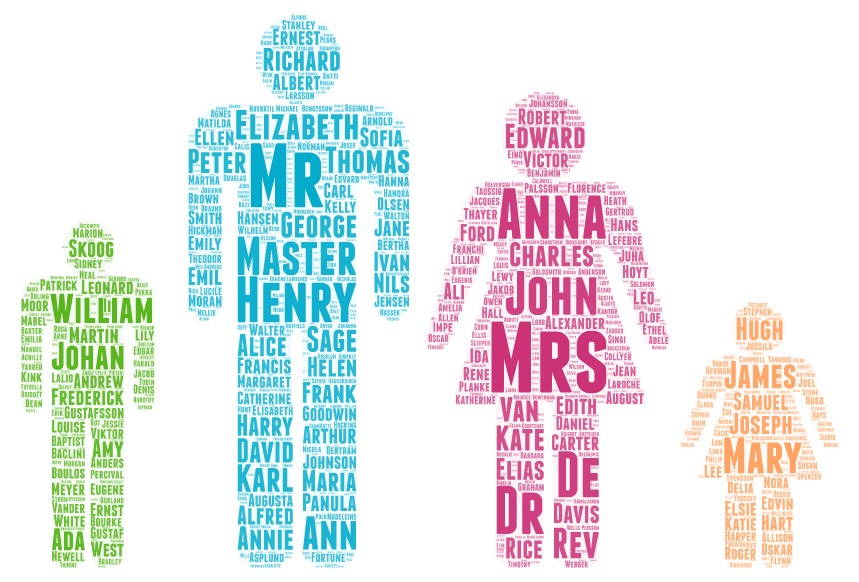

#### Acknowledgements to the [Titanic Tutorial](https://www.kaggle.com/alexisbcook/titanic-tutorial). Image powered by Wordart.com

#### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#### Load the train and test data for the competition

In [2]:
test_data = pd.read_csv("../input/titanic/test.csv")
train_data = pd.read_csv("../input/titanic/train.csv")
print("The training data has the shape: ",train_data.shape)
print("The testing data has the shape: ",test_data.shape)

The training data has the shape:  (891, 12)
The testing data has the shape:  (418, 11)


In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Overall 38% of the passengers in the training set survived

In [4]:
train_data.Survived.value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Survived', ylabel='count'>

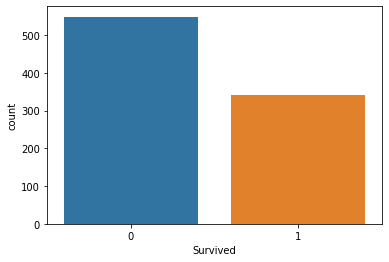

In [5]:
sns.countplot(x="Survived",data=train_data)

#### Most cabin values and many age values are missing.

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Sex is important in determining survival. Women were much more likely to survive than men.

In [7]:
train_data.groupby('Survived')['Sex'].value_counts(normalize = True)

Survived  Sex   
0         male      0.852459
          female    0.147541
1         female    0.681287
          male      0.318713
Name: Sex, dtype: float64

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

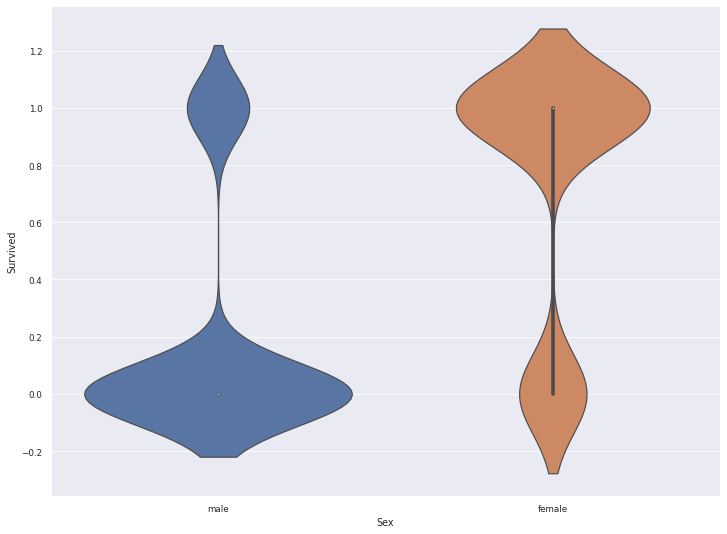

In [8]:
plt.figure(figsize = (12, 9))
sns.set()
sns.set_context("paper")
sns.violinplot(y="Survived", x = 'Sex', data=train_data)

#### Ticket class affects likelihood of survival - positively for 1st class, negatively for 3rd class. 

In [9]:
train_data.groupby('Pclass')['Survived'].value_counts(normalize = True)

Pclass  Survived
1       1           0.629630
        0           0.370370
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

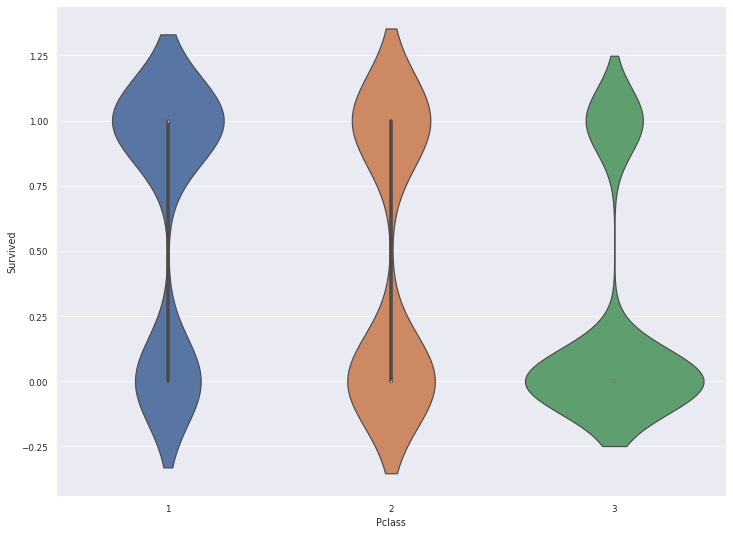

In [10]:
plt.figure(figsize = (12, 9))
sns.set()
sns.set_context("paper")
sns.violinplot(y="Survived", x = 'Pclass', data=train_data)

#### Passengers embark from three locations: Cherbourg, Queenstown & Southampton. Cherbourg has the best survival rate.

In [11]:
train_data.groupby('Embarked')['Survived'].value_counts(normalize = True)

Embarked  Survived
C         1           0.553571
          0           0.446429
Q         0           0.610390
          1           0.389610
S         0           0.663043
          1           0.336957
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

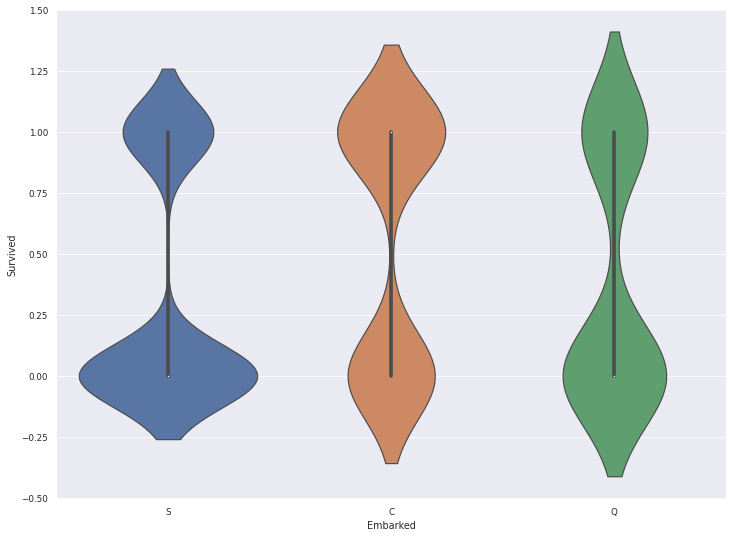

In [12]:
plt.figure(figsize = (12, 9))
sns.set()
sns.set_context("paper")
sns.violinplot(y="Survived", x = 'Embarked', data=train_data)

#### 'Parch' refers to travelling with parents or children. Values 1, 2 and 3 have the best survival rates.

In [13]:
train_data.groupby('Parch')['Survived'].value_counts()

Parch  Survived
0      0           445
       1           233
1      1            65
       0            53
2      0            40
       1            40
3      1             3
       0             2
4      0             4
5      0             4
       1             1
6      0             1
Name: Survived, dtype: int64

#### Though the median age of survivors is the same as that of non-survivors, children are more likely to survive

In [14]:
train_data.groupby('Survived')['Age'].median()

Survived
0    28.0
1    28.0
Name: Age, dtype: float64

<AxesSubplot:xlabel='Survived', ylabel='Age'>

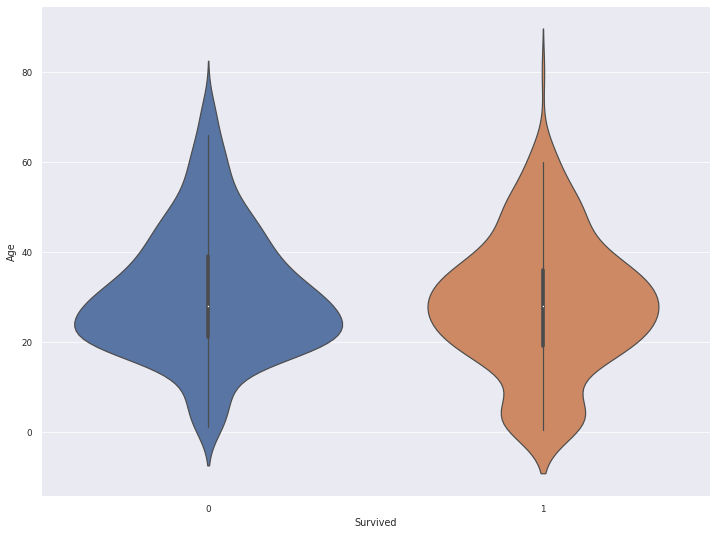

In [15]:
plt.figure(figsize = (12, 9))
sns.violinplot(y="Age", x = "Survived", data=train_data)

#### Under 18s have a 54% chance of survival.

In [16]:
selection = train_data[train_data.Age<18] 
selection.Survived.value_counts(normalize = True)

1    0.539823
0    0.460177
Name: Survived, dtype: float64

#### Let's create a new feature called Under18. Missing values and those 18+ will be allocated 0.

In [17]:
train_data['Under18'] = train_data['Age']<18
test_data["Under18"] = test_data['Age']<18

In [18]:
# This captures Under18s who have 'Master' in their name but whose age is missing
train_data.loc[train_data['Name'].str.contains('Master'), 'Under18'] = True
test_data.loc[test_data['Name'].str.contains('Master'), 'Under18'] = True

#### Travelling with a sibling or a spouse seems to boost survival chances slightly.

In [19]:
train_data.groupby('SibSp')['Survived'].value_counts()

SibSp  Survived
0      0           398
       1           210
1      1           112
       0            97
2      0            15
       1            13
3      0            12
       1             4
4      0            15
       1             3
5      0             5
8      0             7
Name: Survived, dtype: int64

#### Drop unnecessary columns

In [20]:
train_data = train_data.drop(columns = ['Name','PassengerId','Age','Ticket','Cabin'])
test_data = test_data.drop(columns = ['Name','Age','Cabin','Ticket'])

#### Let's use one hot encoding for the 'Sex' and 'Embarked' categories

In [21]:
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)
train_data = train_data.drop(columns = 'Sex_male')
test_data = test_data.drop(columns = 'Sex_male')

#### Let's look at correlations with the target

In [22]:
train_data.corr().Survived.sort_values(ascending = False)

Survived      1.000000
Sex_female    0.543351
Fare          0.257307
Embarked_C    0.168240
Under18       0.123616
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Embarked_S   -0.155660
Pclass       -0.338481
Name: Survived, dtype: float64

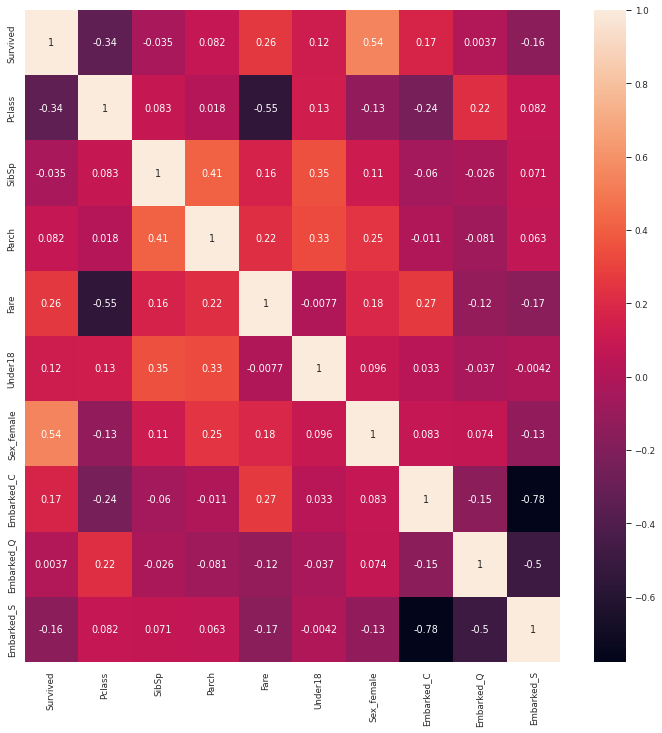

In [23]:
plt.figure(1 , figsize = (12 , 12))
cor = sns.heatmap(train_data.corr(), annot = True)

#### Pclass and Fare show quite a strong correlation. We will drop Fare as it has a weaker target relationship. We will drop Embarked_Q and SibSp which both have low correlations.

In [24]:
test_data = test_data.drop(columns = ['Fare','SibSp','Embarked_Q'])
train_data = train_data.drop(columns = ['Fare','SibSp','Embarked_Q'])

#### Here we select key features for the model

In [25]:
y = train_data["Survived"]
X = train_data.drop(columns ='Survived')
X_test = test_data.drop(columns = 'PassengerId')

#### Create the classifier and find the cross validation score

In [26]:
clf = RandomForestClassifier(max_depth = 5, n_estimators = 70, random_state = 35)

In [27]:
print(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))
print(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

[0.81111111 0.80898876 0.7752809  0.86516854 0.83146067 0.79775281
 0.84269663 0.76404494 0.84269663 0.85393258]
0.8193133583021224


In [28]:
clf.fit(X,y)

RandomForestClassifier(max_depth=5, n_estimators=70, random_state=35)

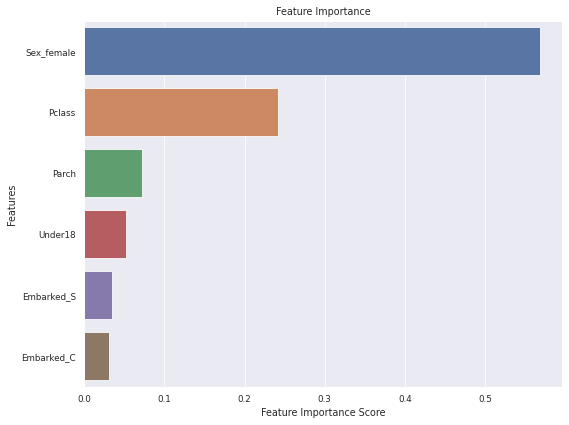

In [29]:
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.tight_layout()

#### Now to make predictions

In [30]:
predictions = clf.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
